<a href="https://colab.research.google.com/github/jeet1912/ms/blob/main/ds677/assignments/DS677Week12HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 9 - Adversarial Attack**


## Enviroment & Download

We make use of [pytorchcv](https://pypi.org/project/pytorchcv/) to obtain CIFAR-10 pretrained model, so we need to set up the enviroment first. We also need to download the data (200 images) which we want to attack.

In [ ]:
# set up environment
!pip install pytorchcv

# download
!gdown --id '1HQRkshrkTfXufzDeeGov_y6vii4Yd52N' -O data.zip

# unzip
!unzip ./data.zip
!rm ./data.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.2/585.2 kB 20.0 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HQRkshrkTfXufzDeeGov_y6vii4Yd52N
To: /content/data.zip
100% 572k/572k [00:00<00:00, 6.83MB/s]
Archive:  ./data.zip
   creating: data/
  inflating: __MACOSX/._data         
   creating: data/cat/
  inflating: __MACOSX/data/._cat     
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/dog/
  inflating: __MACOSX/data/._dog     
   creating: data/truck/
  inflating: __MACOSX/data/._truck   
   creating: data/bird/
  inflating: __MACOSX/data/._bird    
   creating: data/airplane/
  inflating: __MACOSX/data/._airplane

## Global Settings

* $\epsilon$ is fixed to be 8. But on **Data section**, we will first apply transforms on raw pixel value (0-255 scale) **by ToTensor (to 0-1 scale)** and then **Normalize (subtract mean divide std)**. $\epsilon$ should be set to $\frac{8}{255 * std}$ during attack.

* Explaination (optional)
    * Denote the first pixel of original image as $p$, and the first pixel of adversarial image as $a$.
    * The $\epsilon$ constraints tell us $\left| p-a \right| <= 8$.
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.
    * After applying ToTensor() and Normalize() on $p$ and $a$, the constraint becomes $\left| N(T(p))-N(T(a)) \right| = \left| \frac{\frac{p}{255}-mean}{std}-\frac{\frac{a}{255}-mean}{std} \right| = \frac{1}{255 * std} \left| p-a \right| <= \frac{8}{255 * std}.$
    * So, we should set $\epsilon$ to be $\frac{8}{255 * std}$ after ToTensor() and Normalize().

In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8

# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std
# TODO: iterative fgsm attack
# alpha (step size) can be decided by yourself
alpha = 0.8/255/std

root = './data' # directory for storing benign images
# benign images: images which do not contain adversarial perturbations
# adversarial images: images which include adversarial perturbations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

Construct dataset and dataloader from root directory. Note that we store the filename of each image for future usage.

In [ ]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


## Utils -- Benign Images Evaluation

In [ ]:
# to evaluate the performance of model on benign images
def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

## Utils -- Attack Algorithm

In [ ]:
# perform fgsm attack
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone() # initialize x_adv as original benign image x
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    loss = loss_fn(model(x_adv), y) # calculate loss
    loss.backward() # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    x_adv = x_adv + epsilon * x_adv.grad.detach().sign()
    return x_adv

# TODO: perform iterative fgsm attack
# set alpha as the step size in Global Settings section
# alpha and num_iter can be decided by yourself
def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20):
    # initialize x_adv as original benign image x
    x_adv = x.detach().clone()
    # write a loop of num_iter to represent the iterative times
    for _ in range(num_iter):
    # for each loop
        # call fgsm with (epsilon = alpha) to obtain new x_adv
        x_adv = fgsm(model, x_adv, y, loss_fn, epsilon=alpha)
        # clip new x_adv back to [x-epsilon, x+epsilon]
        x_adv = torch.clamp(x_adv, x-epsilon, x+epsilon)
    # return x_adv
    return x_adv

def ifgsm_ensemble(models, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20):
  x_adv = x.detach().clone()
  for _ in range(num_iter):
    x_adv.requires_grad = True
    outputs = torch.stack([model(x_adv) for model in models])
    loss = sum([loss_fn(o, y) for o in outputs]) / len(models)
    for model in models:
      model.zero_grad()
    loss.backward()
    # Apply perturbation based on average gradient
    x_adv.data = x_adv + alpha * x_adv.grad.detach().sign()
    x_adv.data = torch.clamp(x_adv, x - epsilon, x + epsilon)
    x_adv.grad.zero_()
  return x_adv

## Utils -- Attack

* Recall
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.

* Inverse function
    * Inverse Normalize() can be seen as a function where $N^{-1}(x) = x*std+mean$ where $mean$ and $std$ are constants.
    * Inverse ToTensor() can be seen as a function where $T^{-1}(x) = x*255$.

* Special Noted
    * ToTensor() will also convert the image from shape (height, width, channel) to shape (channel, height, width), so we also need to transpose the shape back to original shape.
    * Since our dataloader samples a batch of data, what we need here is to transpose **(batch_size, channel, height, width)** back to **(batch_size, height, width, channel)** using np.transpose.

In [ ]:
# perform adversarial attack and generate adversarial examples
def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn) # obtain adversarial examples
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

def gen_adv_examples_ensemble(models, loader, attack, loss_fn):
  for model in models:
    model.eval()
  adv_examples = None
  train_acc, train_loss = 0.0, 0.0
  adv_names = []

  for i, (x, y) in enumerate(loader):
    x, y = x.to(device), y.to(device)
    x_adv = attack(models, x, y, loss_fn)  # obtain adversarial examples using ensemble
    outputs = torch.stack([model(x_adv) for model in models])
    yp = outputs.mean(dim=0)  # average the outputs from all models
    loss = loss_fn(yp, y)
    train_acc += (yp.argmax(dim=1) == y).sum().item()
    train_loss += loss.item() * x.shape[0]
    # Store adversarial examples
    adv_ex = ((x_adv) * std + mean).clamp(0, 1)  # to 0-1 scale
    adv_ex = (adv_ex * 255).clamp(0, 255)  # 0-255 scale
    adv_ex = adv_ex.detach().cpu().data.numpy().round()  # round to remove decimal part
    adv_ex = adv_ex.transpose((0, 2, 3, 1))  # transpose (bs, C, H, W) back to (bs, H, W, C)
    if adv_examples is None:
      adv_examples = adv_ex
    else:
      adv_examples = np.vstack((adv_examples, adv_ex))
    adv_names.extend([f'img_{i*loader.batch_size + j}.png' for j in range(x.shape[0])])
  return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8)) # image pixel value should be unsigned int
        im.save(os.path.join(adv_dir, name))

## Model / Loss Function

Model list is available [here](https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/model_provider.py). Please select models which has _cifar10 suffix. Some of the models cannot be accessed/loaded. You can safely skip them since TA's model will not use those kinds of models.

In [ ]:
from pytorchcv.model_provider import get_model as ptcv_get_model

models_to_test = ['resnet110_cifar10','resnet20_cifar10', 'densenet40_k12_cifar10', 'nin_cifar10', 'resnet1202_cifar10',
                  'wrn28_10_cifar10', 'pyramidnet110_a48_cifar10', 'se_resnet56_cifar10',
                  'resnext29_8x64d_cifar10', 'shufflenet_g1_cifar10', 'densenet100_k12_bc_cifar10',
                  'googlenet_cifar10', 'xception_cifar10']

best_model = None
best_accuracy = 0.0
best_loss = float('inf')

for model_name in models_to_test:
  try:
    # Get the model
    model = ptcv_get_model(model_name, pretrained=True).to(device)
    # Define loss function
    loss_fn = nn.CrossEntropyLoss()
    # Evaluate the model (assuming 'epoch_benign' function exists)
    benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn)
    print(f'{model_name}: benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')
    # Check if this model performs better
    if benign_acc > best_accuracy or (benign_acc == best_accuracy and benign_loss < best_loss):
      best_accuracy = benign_acc
      best_loss = benign_loss
      best_model = model
      best_model_name = model_name
  except Exception as e:
    print(f"Error testing {model_name}: {str(e)}")
    continue

# Assign the best performing model to 'model'
if best_model is not None:
  model = best_model
  print(f'\nBest model chosen: {best_model_name}')
  print(f'With accuracy: {best_accuracy:.5f} and loss: {best_loss:.5f}')
else:
  print("No model could be tested successfully.")

resnet110_cifar10: benign_acc = 0.95000, benign_loss = 0.22678
resnet20_cifar10: benign_acc = 0.94500, benign_loss = 0.17499
densenet40_k12_cifar10: benign_acc = 0.93000, benign_loss = 0.23954
nin_cifar10: benign_acc = 0.91500, benign_loss = 0.30363
resnet1202_cifar10: benign_acc = 0.97000, benign_loss = 0.17800
wrn28_10_cifar10: benign_acc = 0.96000, benign_loss = 0.17589
pyramidnet110_a48_cifar10: benign_acc = 0.96000, benign_loss = 0.17974
Error testing se_resnet56_cifar10: Unsupported model: se_resnet56_cifar10
Error testing resnext29_8x64d_cifar10: Unsupported model: resnext29_8x64d_cifar10
Error testing shufflenet_g1_cifar10: Unsupported model: shufflenet_g1_cifar10
densenet100_k12_bc_cifar10: benign_acc = 0.95500, benign_loss = 0.34458
Error testing googlenet_cifar10: Unsupported model: googlenet_cifar10
Error testing xception_cifar10: Unsupported model: xception_cifar10

Best model chosen: resnet1202_cifar10
With accuracy: 0.97000 and loss: 0.17800


## FGSM

In [ ]:
adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(model, adv_loader, fgsm, loss_fn)
print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'fgsmResnet1202', adv_examples, adv_names)

fgsm_acc = 0.73000, fgsm_loss = 1.65091


## I-FGSM

In [ ]:
# TODO: iterative fgsm attack
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, ifgsm, loss_fn)
print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ifgsmResnet1202', adv_examples, adv_names)

ifgsm_acc = 0.13000, ifgsm_loss = 12.78460


Given this accuracy for comparable benchmarks, I-FGSM attacks will be chosen for proxy attacks.

## I-FGSM Ensemble

Models were selected using their best accuracy scores on benign samples. Clearly, it's performance will be dependent on them.

In [ ]:
proxy_models = [
  #ptcv_get_model('resnet1202_cifar10', pretrained=True).to(device),
  #ptcv_get_model('densenet100_k12_bc_cifar10', pretrained=True).to(device),
  ptcv_get_model('wrn28_10_cifar10', pretrained=True).to(device),
  ptcv_get_model('pyramidnet110_a48_cifar10', pretrained=True).to(device),
]

adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples_ensemble(proxy_models, adv_loader, ifgsm_ensemble, loss_fn)
print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ifgsmEnsemble#2', adv_examples, adv_names)

ifgsm_acc = 0.03000, ifgsm_loss = 20.18925


## Compress the images

In [ ]:
%cd fgsm
!tar zcvf ../fgsm.tgz *
%cd ..

%cd ifgsm
!tar zcvf ../ifgsm.tgz *
# %cd ..

Streaming output truncated to the last 5000 lines.
tar: drive/MyDrive/ds677/week7/__MACOSX/faces/._13603.jpg: file changed as we read it
drive/MyDrive/ds677/week7/__MACOSX/faces/._13614.jpg
tar: drive/MyDrive/ds677/week7/__MACOSX/faces/._13614.jpg: file changed as we read it
drive/MyDrive/ds677/week7/__MACOSX/faces/._13563.jpg
tar: drive/MyDrive/ds677/week7/__MACOSX/faces/._13563.jpg: file changed as we read it
drive/MyDrive/ds677/week7/__MACOSX/faces/._13616.jpg
tar: drive/MyDrive/ds677/week7/__MACOSX/faces/._13616.jpg: file changed as we read it
drive/MyDrive/ds677/week7/__MACOSX/faces/._13416.jpg
tar: drive/MyDrive/ds677/week7/__MACOSX/faces/._13416.jpg: file changed as we read it
drive/MyDrive/ds677/week7/__MACOSX/faces/._13415.jpg
tar: drive/MyDrive/ds677/week7/__MACOSX/faces/._13415.jpg: file changed as we read it
drive/MyDrive/ds677/week7/__MACOSX/faces/._13428.jpg
tar: drive/MyDrive/ds677/week7/__MACOSX/faces/._13428.jpg: file changed as we read it
drive/MyDrive/ds677/week7/__M

The code started using a plausible system cache file from the drive link submitted for week7. Upon reattempting the setup, a new system cache file was created
under the appropriate root folder of colab's directory.

In [ ]:
from google.colab import drive
import os
import shutil
import tarfile

source_path = '/content/ifgsmEnsemble#2'
destination_path = '/content/drive/MyDrive/ds677/week12/compressedForEnsembleIFGSM2.tar.gz'

with tarfile.open(destination_path, "w:gz") as tar:
  tar.add(source_path, arcname=os.path.basename(source_path))

## Visualization

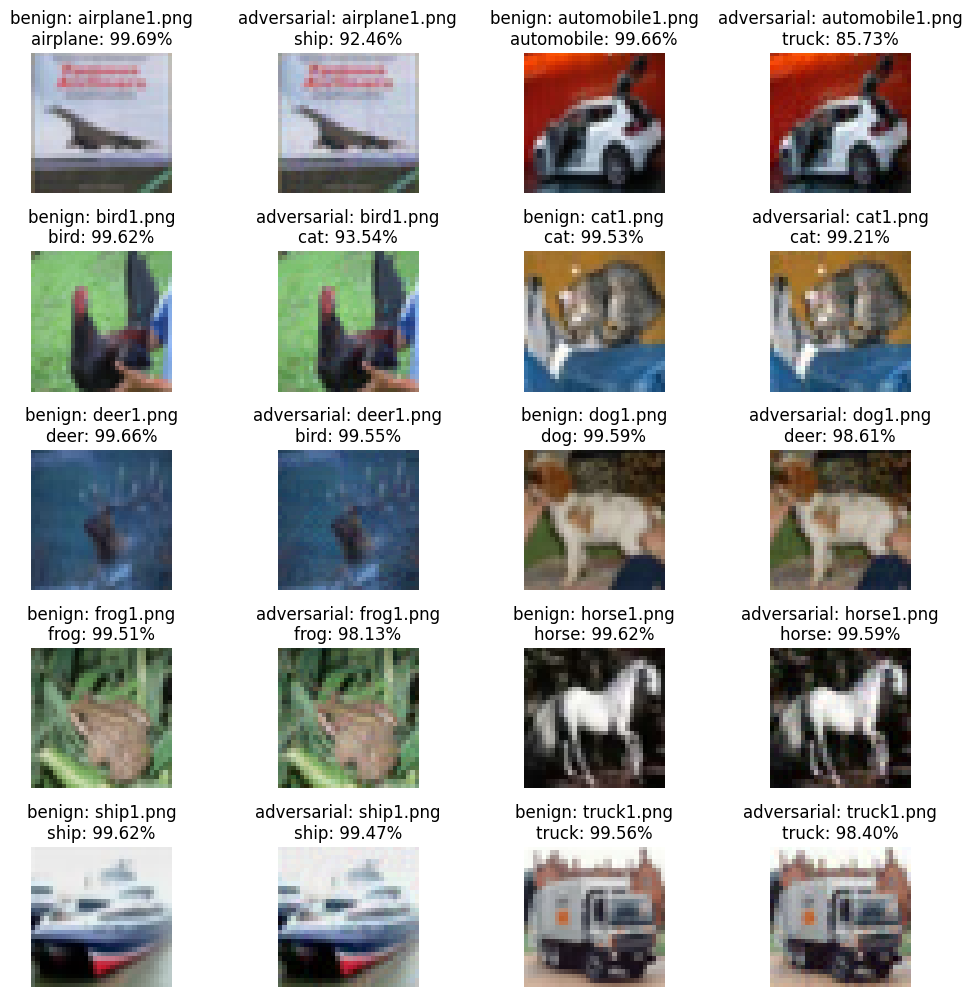

In [ ]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
  path = f'{cls_name}/{cls_name}1.png'
  # benign image
  cnt += 1
  plt.subplot(len(classes), 4, cnt)
  im = Image.open(f'./data/{path}')
  logit = model(transform(im).unsqueeze(0).to(device))[0]
  predict = logit.argmax(-1).item()
  prob = logit.softmax(-1)[predict].item()
  plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
  plt.axis('off')
  plt.imshow(np.array(im))
  # adversarial image
  cnt += 1
  plt.subplot(len(classes), 4, cnt)
  im = Image.open(f'./ifgsmEnsemble#2/{path}')
  logit = model(transform(im).unsqueeze(0).to(device))[0]
  predict = logit.argmax(-1).item()
  prob = logit.softmax(-1)[predict].item()
  plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
  plt.axis('off')
  plt.imshow(np.array(im))
plt.tight_layout()
plt.show()